In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import torchvision

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision import transforms

# Définition des transformations incluant l'augmentation de données
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Redimensionnement
    transforms.RandomHorizontalFlip(), # Flip horizontal aléatoire
    transforms.RandomRotation(10), # Rotation aléatoire de +/- 10 degrés
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Variation aléatoire de la luminosité, du contraste et de la saturation
    transforms.ToTensor(), # Conversion en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisation
])


In [4]:
# Chemin d'accès au dataset PHOTOCL
data_dir = '/kaggle/input/photocl/dataset_original'

# Création du dataset avec les transformations définies
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Création d'un DataLoader pour itérer sur le dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


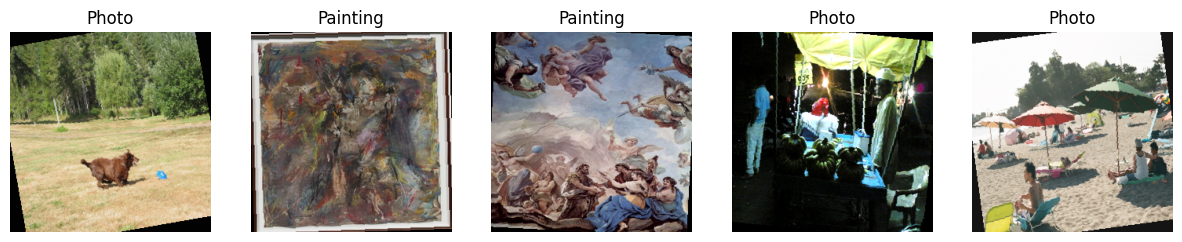

In [5]:
def imshow_individual(images, labels, dataset, num_images=5):
    """Afficher individuellement les images avec leurs titres."""
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 3))
    for i, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):
        ax = axes[i]
        img = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(dataset.classes[label])
        ax.axis('off')
    plt.show()

# Utilisation de la fonction
images, labels = next(iter(dataloader))
imshow_individual(images, labels, dataset)


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Chemin du dataset original
data_dir = '/kaggle/input/photocl/dataset_original'

# Chemins des dossiers de destination
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

# Create directories for binary classification
for folder in [train_dir, val_dir, test_dir]:
    for class_name in ['Photo', 'Others']:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)


In [7]:

# Function to split data into train, validation, and test sets
def split_data(source, train_dir, val_dir, test_dir):
    # Get all files in the source directory
    files = [os.path.join(source, f) for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    
    # First split: 70% for train+validation and 30% for test
    train_validation_paths, test_paths = train_test_split(files, test_size=0.3, random_state=42)
    
    # Second split: From the 70% train+validation, split into 55% train and 15% validation
    train_paths, validation_paths = train_test_split(train_validation_paths, test_size=0.2, random_state=42)  # 15% of 70% for validation
    
    # Function to copy files to a destination directory
    def copy_files(file_paths, destination):
        os.makedirs(destination, exist_ok=True)  # Create the destination directory if it doesn't exist
        for file_path in file_paths:
            shutil.copy(file_path, destination)
    
    # Copy files to their respective directories
    copy_files(train_paths, train_dir)
    copy_files(validation_paths, val_dir)
    copy_files(test_paths, test_dir)

# Apply the split_data function to each class
for class_name in ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']:
    class_dir = os.path.join(data_dir, class_name)
    if class_name == 'Photo':
        split_data(class_dir, os.path.join(train_dir, 'Photo'), os.path.join(val_dir, 'Photo'), os.path.join(test_dir, 'Photo'))
    else:
        split_data(class_dir, os.path.join(train_dir, 'Others'), os.path.join(val_dir, 'Others'), os.path.join(test_dir, 'Others'))
        

print("Dataset splitting completed!")

Dataset splitting completed!


In [8]:
import os
import matplotlib.pyplot as plt

# Chemins des dossiers
base_dir = '/kaggle/input/photocl/dataset_original'  # Chemin vers le dataset original
train_dir = '/kaggle/working/train'  # Chemin vers les données d'entraînement
val_dir = '/kaggle/working/val'      # Chemin vers les données de validation
test_dir = '/kaggle/working/test'    # Chemin vers les données de test

def count_images(directory):
    """ Compte les images dans chaque sous-dossier d'un répertoire donné. """
    counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

# Comptage des images dans chaque ensemble
original_counts = count_images(base_dir)
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)


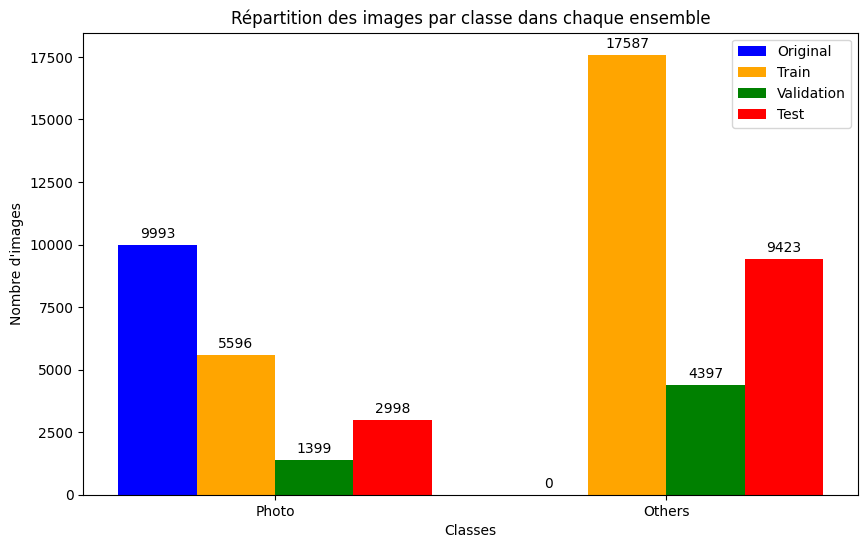

In [10]:
import os
import matplotlib.pyplot as plt

# Fonction pour compter les images
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len([item for item in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, item))])
    return counts

# Chemins des dossiers
base_dir = '/kaggle/input/photocl/dataset_original'  # Chemin vers le dataset original
train_dir = '/kaggle/working/train'  # Chemin vers les données d'entraînement
val_dir = '/kaggle/working/val'      # Chemin vers les données de validation
test_dir = '/kaggle/working/test'    # Chemin vers les données de test

# Obtenir les comptages pour chaque ensemble
original_counts = count_images(base_dir)
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Préparation des données pour le graphique
classes = ['Photo', 'Others']  # Only two classes
original_data = [original_counts.get(cls, 0) for cls in classes]  # Use .get() to handle missing keys
train_data = [train_counts.get(cls, 0) for cls in classes]
val_data = [val_counts.get(cls, 0) for cls in classes]
test_data = [test_counts.get(cls, 0) for cls in classes]

# Création du graphique
x = range(len(classes))  # Position des barres sur l'axe des x
width = 0.2  # Largeur des barres

fig, ax = plt.subplots(figsize=(10, 6))

# Ajouter les barres pour chaque ensemble de données
bar1 = ax.bar(x, original_data, width, label='Original', align='center', color='blue')
bar2 = ax.bar([p + width for p in x], train_data, width, label='Train', align='center', color='orange')
bar3 = ax.bar([p + 2 * width for p in x], val_data, width, label='Validation', align='center', color='green')
bar4 = ax.bar([p + 3 * width for p in x], test_data, width, label='Test', align='center', color='red')

# Ajouter des étiquettes sur chaque barre
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Ajouter les étiquettes aux barres
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)

# Configurer les axes et le titre
ax.set_xlabel('Classes')
ax.set_ylabel('Nombre d\'images')
ax.set_title('Répartition des images par classe dans chaque ensemble')
ax.set_xticks([p + 1.5 * width for p in x])
ax.set_xticklabels(classes)
ax.legend()

# Afficher le graphique
plt.show()

In [11]:
import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir le périphérique pour l'exécution du modèle (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir les chemins vers les dossiers de données
base_dir = '/kaggle/input/photocl'  # Assurez-vous que ce chemin est correct
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

# Transformations pour les images d'entraînement et de validation
transformations = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Chargement des datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transformations['train'])
val_dataset = datasets.ImageFolder(root=val_dir, transform=transformations['val'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=transformations['val'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Charger un modèle pré-entraîné ResNet50
model = models.resnet50(pretrained=True)  # Pre-trained ResNet50

# Geler les paramètres du modèle pour ne pas les réentraîner, sauf la dernière couche
for param in model.parameters():
    param.requires_grad = False

# Remplacer la dernière couche fully connected pour la classification binaire
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Déplacer le modèle sur le périphérique approprié
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Fonction de perte
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with Logits

# Optimiseur - ne mettre à jour que les paramètres de la dernière couche
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


In [14]:
from tqdm import tqdm  # Import tqdm for progress bars
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Wrap the train_loader with tqdm for a progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

        # Training phase
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Labels must be float for BCEWithLogitsLoss

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze(1)  # Squeeze to match labels shape
                preds = torch.round(torch.sigmoid(outputs))  # Convert logits to binary predictions
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update the progress bar description with the current loss
            train_loader_tqdm.set_postfix(loss=loss.item())

        # Calculate training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print('-' * 50)

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    # Wrap the data_loader with tqdm for a progress bar
    data_loader_tqdm = tqdm(data_loader, desc="[Validation]", leave=False)

    with torch.no_grad():
        for inputs, labels in data_loader_tqdm:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Labels must be float for BCEWithLogitsLoss

            # Forward pass
            outputs = model(inputs).squeeze(1)  # Squeeze to match labels shape
            preds = torch.round(torch.sigmoid(outputs))  # Convert logits to binary predictions
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update the progress bar description with the current loss
            data_loader_tqdm.set_postfix(loss=loss.item())

    # Calculate validation loss and accuracy
    val_loss = running_loss / len(data_loader.dataset)
    val_acc = running_corrects.double() / len(data_loader.dataset)

    return val_loss, val_acc

# Launch training
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10
Train Loss: 0.1818, Train Acc: 0.9382
Val Loss: 0.1019, Val Acc: 0.9624
--------------------------------------------------


Epoch 2/10
Train Loss: 0.1119, Train Acc: 0.9593
Val Loss: 0.0825, Val Acc: 0.9700
--------------------------------------------------


Epoch 3/10
Train Loss: 0.1006, Train Acc: 0.9633
Val Loss: 0.0707, Val Acc: 0.9760
--------------------------------------------------


Epoch 4/10
Train Loss: 0.0913, Train Acc: 0.9673
Val Loss: 0.0634, Val Acc: 0.9767
--------------------------------------------------


Epoch 5/10
Train Loss: 0.0879, Train Acc: 0.9679
Val Loss: 0.0587, Val Acc: 0.9777
--------------------------------------------------


Epoch 6/10
Train Loss: 0.0886, Train Acc: 0.9686
Val Loss: 0.0581, Val Acc: 0.9784
--------------------------------------------------


Epoch 7/10
Train Loss: 0.0773, Train Acc: 0.9727
Val Loss: 0.0752, Val Acc: 0.9722
--------------------------------------------------


Epoch 8/10
Train Loss: 0.0787, Train Acc: 0.9723
Val Loss: 0.0570, Val Acc: 0.9795
--------------------------------------------------


Epoch 9/10
Train Loss: 0.0768, Train Acc: 0.9723
Val Loss: 0.0536, Val Acc: 0.9808
--------------------------------------------------


Epoch 10/10
Train Loss: 0.0749, Train Acc: 0.9725
Val Loss: 0.0550, Val Acc: 0.9805
--------------------------------------------------


In [15]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0586, Test Accuracy: 0.9807


In [16]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import numpy as np


In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Determine the device used by the model

    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)  # Labels must be float for BCEWithLogitsLoss

            # Forward pass
            outputs = model(inputs).squeeze(1)  # Squeeze to match labels shape
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Convert logits to binary predictions
            preds = torch.round(torch.sigmoid(outputs))  # Binary predictions (0 or 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')  # Use 'binary' for binary classification
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Others', 'Photo'])

    # Print results
    print(f"Loss: {total_loss / len(data_loader.dataset):.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Others', 'Photo'], yticklabels=['Others', 'Photo'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, total_loss / len(data_loader.dataset), f1, report, cm

Loss: 0.0586, Accuracy: 0.9807, F1-Score: 0.9592
Classification Report:
              precision    recall  f1-score   support

      Others       0.98      0.99      0.99      9423
       Photo       0.98      0.94      0.96      2998

    accuracy                           0.98     12421
   macro avg       0.98      0.97      0.97     12421
weighted avg       0.98      0.98      0.98     12421

Confusion Matrix:
[[9359   64]
 [ 176 2822]]


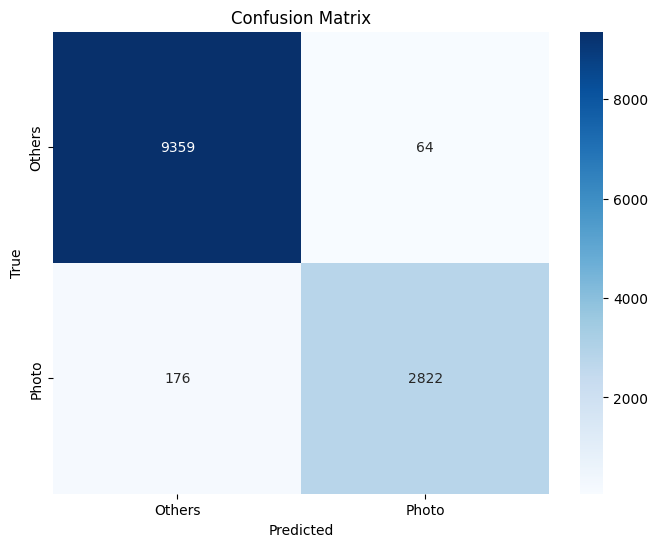

In [18]:
test_accuracy, test_loss, test_f1, test_report, test_cm = evaluate_model(model, test_loader, criterion)


In [20]:
torch.save(model, 'resnet_photocl_full.pth')
